# Train a logistic regression classifier on all datasets and establish a regularization parameter

In [1]:
import os
import sys
import pickle
import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
sys.path.append('../')

import core.core_functions as cf
import core.dataset_functions as df
import core.plot_functions as pf

land_masked = True
global_mean = True
dataset_type = 'absolute_historical'
# set to a not-None value to draw the same random samples for repeated calls
random_init = 6546

savename_append = ''

ERROR 1: PROJ: proj_create_from_database: Open of /jetfs/home/lbrunner/.conda/envs/model_learning/share/proj failed


## Load and prepare training samples

In [2]:
# NOTE: we want the same amount of samples in the observation and the model category
# therefore we call get_samples separately for both categories and change the number
# of time steps selected
samples_model = cf.get_samples(
    period=slice('1982', '2001'), 
    land_masked=land_masked,
    global_mean=global_mean,
    dataset_type=dataset_type,
    time_steps=200, 
    random_init=random_init, 
    verbose=True, 
    datasets=df.model_names,  # 43 models
)

samples_obs = cf.get_samples(
    period=slice('1982', '2001'), 
    land_masked=land_masked,
    global_mean=global_mean,
    dataset_type=dataset_type,
    time_steps=2150,  # 200*43/4
    random_init=random_init, 
    verbose=True,
    datasets=df.observation_names,  # 4 observations
)

samples = xr.concat([samples_model, samples_obs], dim='sample')

Number of datasets: 43
Loaded dataset ACCESS-CM2
Loaded dataset ACCESS-ESM1-5
Loaded dataset AWI-CM-1-1-MR
Loaded dataset AWI-ESM-1-1-LR
Loaded dataset BCC-CSM2-MR
Loaded dataset BCC-ESM1
Loaded dataset CAMS-CSM1-0
Loaded dataset CESM2-WACCM
Loaded dataset CESM2
Loaded dataset CMCC-CM2-HR4
Loaded dataset CMCC-CM2-SR5
Loaded dataset CMCC-ESM2
Loaded dataset CNRM-CM6-1-HR
Loaded dataset CNRM-CM6-1
Loaded dataset CNRM-ESM2-1
Loaded dataset CanESM5
Loaded dataset EC-Earth3-AerChem
Loaded dataset EC-Earth3-Veg-LR
Loaded dataset EC-Earth3-Veg
Loaded dataset EC-Earth3
Loaded dataset FGOALS-f3-L
Loaded dataset FGOALS-g3
Loaded dataset GFDL-CM4
Loaded dataset GFDL-ESM4
Loaded dataset HadGEM3-GC31-LL
Loaded dataset HadGEM3-GC31-MM
Loaded dataset INM-CM4-8
Loaded dataset INM-CM5-0
Loaded dataset IPSL-CM5A2-INCA
Loaded dataset IPSL-CM6A-LR
Loaded dataset KACE-1-0-G
Loaded dataset KIOST-ESM
Loaded dataset MIROC-ES2L
Loaded dataset MIROC6
Loaded dataset MPI-ESM-1-2-HAM
Loaded dataset MPI-ESM1-2-HR
L

In [3]:
# 1D freature dimension
samples = samples.stack(feature=['lat', 'lon'])
XX = samples.values
yy = df.get_category_ids(samples['dataset_name'].values)

nan_mask = np.any(np.isnan(XX), axis=0)
XX = XX[:, ~nan_mask]

print('Number of features:', XX.shape[1])
print('Number of samples per category:', np.unique(yy, return_counts=True)[1])

Number of features: 6888
Number of samples per category: [8600 8600]


## Set up cross validation to establish regularization

In [4]:
logreg = LogisticRegression(penalty='l2', solver='liblinear')
grid = {'C': np.logspace(-5, -1, 20)}

# 5-fold cross validation on shuffled training data
XX, yy = shuffle(XX, yy, random_state=random_init)
cv = 5

# alternatively we could do folds for each dataset or dataset group
# groups = samples['dataset_name'].values  # one fold for each dataset
# groups = df.get_groups(samples['dataset_name'].values)  # one fold for each group
# cv = GroupKFold(n_splits=len(np.unique(groups)))
# print('Number of dataset groups (=folds):', cv.n_splits)
# cv.split(XX, yy, groups)

logreg_cv = GridSearchCV(
    estimator=logreg, 
    param_grid=grid, 
    cv=cv, 
    n_jobs=20, 
    return_train_score=True,
)

## Train classifier

In [5]:
logreg_cv.fit(XX, yy)
print(f'{logreg_cv.best_params_=}')

logreg_cv.best_params_={'C': 0.023357214690901212}


## Training accuracy

In [7]:
logreg_cv.score(XX, yy)

1.0

## Plot classifier properties

### Regularization strength

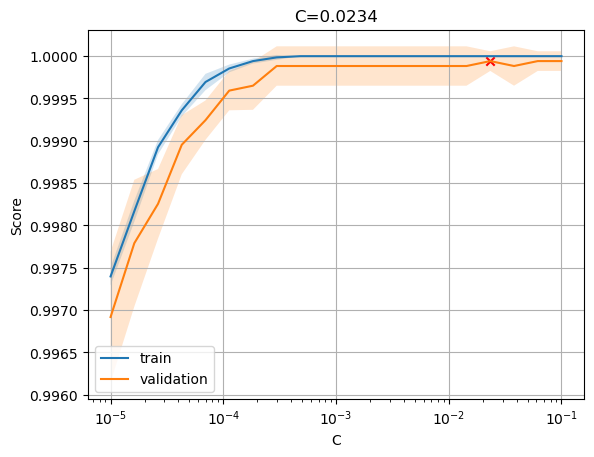

In [8]:
pf.plot_hyper_param(logreg_cv, 'C', xscale='log')

### Regression weights

<GeoAxesSubplot: title={'center': 'Regression coefficients'}>

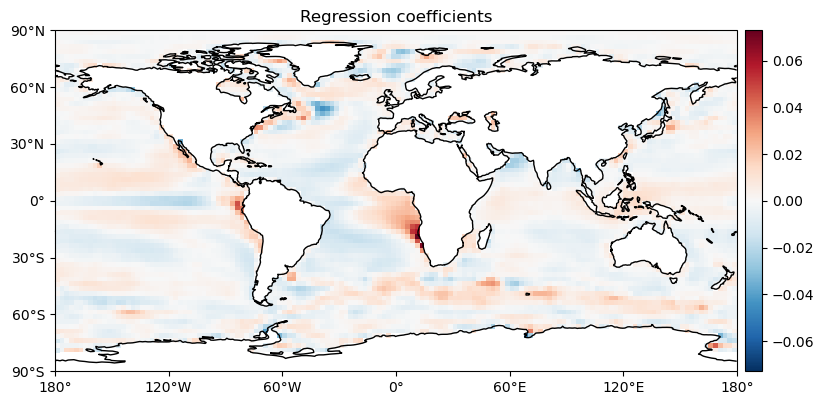

In [9]:
pf.plot_coef_map(logreg_cv.best_estimator_)

## Reliability diagram

<AxesSubplot: xlabel='Confidence', ylabel='Accuracy'>

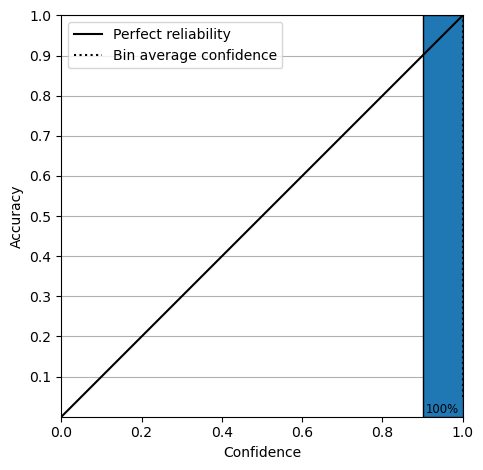

In [10]:
pf.plot_reliability_diagram(logreg_cv, XX, yy)

## Set fixed regularisation parameter

In [15]:
logreg = LogisticRegression(
    penalty='l2', 
    solver='liblinear', 
    C=.002,  # same as in Brunner and Sippel (2020)
)
logreg.fit(XX, yy)

LogisticRegression(C=0.002, solver='liblinear')

<GeoAxesSubplot: title={'center': 'Regression coefficients'}>

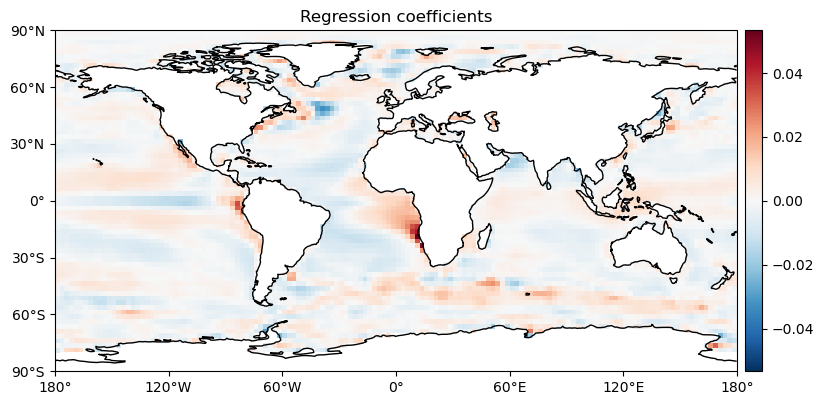

In [16]:
pf.plot_coef_map(logreg)

## Save trained classifier

In [17]:
savename =  'binary_logreg_{}{}{}.sav'.format(
    dataset_type,
    ('_lm' if land_masked else '') + ('_gm' if global_mean else ''),
    savename_append
)
pickle.dump(
    logreg, 
    open(os.path.join('../../data/trained_classifiers', savename), 'wb'))